In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

# Naive CF-Descent

This file contains the initial attempts at making CF-Descent work and tests to see it's validity

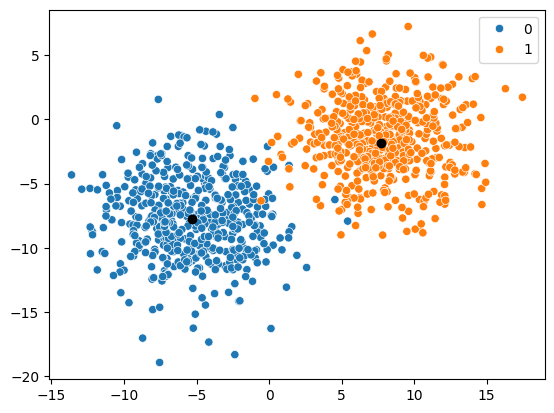

In [37]:
X, y, centers = make_blobs(centers=2, cluster_std=3, n_features=2, n_samples=1000, return_centers=True)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.scatter(x=centers[0][0], y=centers[0][1],color="black")
plt.scatter(x=centers[1][0], y=centers[1][1],color="black")

In [38]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,label
0,-3.622697,-1.147498,0.0
1,1.433447,-5.256647,1.0
2,8.810898,1.571568,1.0
3,-3.902015,-8.833487,0.0
4,-7.200958,-4.445353,0.0
...,...,...,...
995,9.592810,7.247417,1.0
996,-11.841879,-11.733729,0.0
997,-6.953329,-6.504375,0.0
998,8.551111,-0.130994,1.0


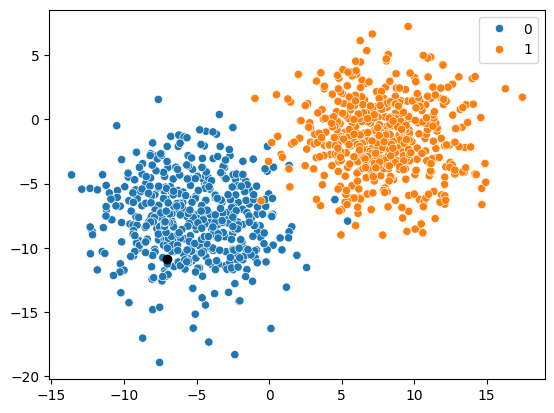

In [39]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=df.values[5][0],y=df.values[5][1],color='black')

In [146]:
def euclid_dis(x,y):
    return np.linalg.norm(x-y)

3.905124837953327

In [202]:
def Naive_CF_Descent(df, model, target, centers, instance_index, stop_count, step_size, limit = 50000, dis = lambda a,b : euclid_dis(a,b)):
    cf = centers[int(target)]
    target_points = df[df["label"] == target]

    history = []
    misses = 0
    instance = df.values[instance_index]
    if instance[-1] == target:
        raise Exception("cannot create CF for current class")
    instance = instance[:-1]

    it = 0
    while misses < stop_count and it < limit:
        y = target_points.sample().values[0][:-1]
        changes = []
        current_dis = dis(cf, instance)

        for i in range(len(y)):
            cf_prime = cf.copy()

            step = y[i] - cf_prime[i]
            
            cf_prime[i] += step * step_size

            distance_new = dis(cf_prime, instance)

            if distance_new < current_dis:
                changes.append((cf_prime,distance_new))

        if len(changes) == 0:
            misses += 1
        else:
            best = min(changes, key = lambda x: x[1])[0]
            if all([x == y for x,y in zip(cf,best)]):
                misses += 1
            else:    
                try:
                    prediction = model.predict([best])
                    if prediction[0] != int(target):
                        misses += 1
                        it += 1
                    else:
                        cf = best
                        misses = 0
                        history.append(best)
                except ValueError:
                    print("fail")
                    misses += 1
        it += 1

    if len(history) == 0:
        history.append((cf,0))
    print("Amount of changes: ", len(history))
    return instance,cf,history

In [203]:
x,cf,h = Naive_CF_Descent(df,model, target=1.0, centers=centers, instance_index=31, stop_count=50, step_size=0.6, limit=1000)

Amount of changes:  704


[array([ 7.72326986, -4.85225139]), array([ 6.62109393, -4.85225139]), array([ 6.94189748, -1.29694957]), array([6.13551131, 1.14069473]), array([ 7.72326986, -0.66053335]), array([ 7.06428585, -0.66053335]), array([5.92421936, 1.42102408]), array([ 7.72326986, -0.9300211 ]), array([ 6.35994071, -0.9300211 ]), array([ 7.72326986, -0.76273601]), array([ 6.46645178, -0.76273601]), array([ 6.35533871, -1.53798794]), array([ 7.72326986, -1.48740381]), array([ 5.24339647, -1.48740381]), array([ 7.72326986, -2.17373397]), array([ 7.72326986, -3.50387786]), array([ 4.77384573, -3.50387786]), array([ 5.69057633, -1.55948115]), array([ 6.16885171, -2.78410437]), array([ 6.51717655, -0.36465564]), array([ 7.38319108, -3.25052761]), array([ 5.94039343, -4.7402742 ]), array([ 7.34956983, -3.6886921 ]), array([ 7.72326986, -3.0584195 ]), array([ 6.09342586, -3.0584195 ]), array([ 5.05057957, -5.43914713]), array([ 7.72326986, -6.14801876]), array([ 7.72326986, -6.28499891]), array([ 6.99644638, -6.

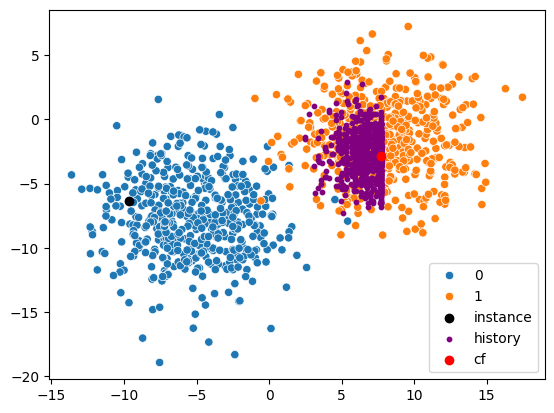

In [204]:
print(h)
hx = list(zip(*h))[0]
hy = list(zip(*h))[1]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=x[0],y=x[1],color='black',label='instance')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.scatter(x=cf[0],y=cf[1],color='red', label='cf')
plt.legend()